# Задача 3
Решить краевую задачу\
$
\begin{cases}
    y'' + (x^2 - 3)y' + (x^2 - 3)\cos x \cdot y = 2 - 6x + 2x^3 + (x^2 - 3)e^x \sin x (1 + \cos x) + \cos x (e^x + (x^2-1) + x^4 - 3x^2)\\
    y(0) = 0\\
    y(\pi) = \pi ^ 2
\end{cases}
$

## 1. Метод прогонки
Задача линейная, дискретизуем и сводем к системе линейных уравнений, которую решим методом прогонки\
**Метод неустойчивый!**

In [15]:
from math import exp, sin, cos, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# метод прогонки (tridiagonal matrix algorithm)
def TMA(a_arr, b_arr, c_arr, d_arr):
    N_pr = len(a_arr)
    p_arr = [0] * N_pr
    q_arr = [0] * N_pr
    x_arr = [0] * N_pr

    # i = 0
    p_arr[1] = -c_arr[0] / b_arr[0]
    q_arr[1] = d_arr[0] / b_arr[0]

    # i = 1, ..., N - 1
    for i in range(2, N_pr, 1):
        p_arr[i] = -c_arr[i - 1] / (a_arr[i - 1] * p_arr[i - 1] + b_arr[i - 1])
        q_arr[i] = (d_arr[i - 1] - a_arr[i - 1] * q_arr[i - 1]) / (a_arr[i - 1] * p_arr[i - 1] + b_arr[i - 1])

    x_arr[N_pr - 1] = (d_arr[N_pr - 1] - a_arr[N_pr - 1] * q_arr[N_pr - 1]) / (p_arr[N_pr - 1] * a_arr[N_pr - 1] + b_arr[N_pr - 1])
    
    # обратный ход
    for i in range(N_pr - 2, -1, -1):
        x_arr[i] = x_arr[i + 1] * p_arr[i + 1] + q_arr[i + 1]
    
    return x_arr


# функции (коэффициенты в уравнении)
def g(x):
    # x - точка
    # y - начальное приближение в точке x
    # y_der1 - производная начального приближения в точке x
    # y_der2 - вторая производная начального приближения в точке x
    return x ** 2 - 3

def h(x):
    return x ** 2 - 3

def f(x):
    return 2 - 6 * x + 2 * x ** 3 + (x ** 2 - 3) * exp(x) * sin(x) * (1 + cos(x)) + cos(x) * (exp(x) + (x ** 2 - 1) + x ** 4 - 3 * x ** 2)


# вектор-функции (коэффициенты в уравнении)
def g_vec(x_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(N):
        ret[i] = g(x_arr[i])
    return ret

def h_vec(x_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(N):
        ret[i] = h(x_arr[i])
    return ret

def f_vec(x_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(N):
        ret[i] = f(x_arr[i])
    return ret


# коэффициенты для матрицы из метода прогонки
def a_n(tau, g_n, h_n, f_n):
    return 1 + tau * g_n

def b_n(tau, g_n, h_n, f_n):
    return -2 - tau * g_n + tau ** 2 * h_n

def c_n(tau, g_n, h_n, f_n):
    return 1

def d_n(tau, g_n, h_n, f_n):
    return tau ** 2 * f_n


# векторы коэффициентов для матрицы из метода прогонки
def a_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # a(0) = a(N) = 0, a(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [0] * N
    for i in range(1, N - 1, 1):
        ret[i] = a_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret

def b_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # b(0) = b(N) = 1, b(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [1] * N
    for i in range(1, N - 1, 1):
        ret[i] = b_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret

def c_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # c(0) = c(N) = 0, c(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [0] * N
    for i in range(1, N - 1, 1):
        ret[i] = c_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret

def d_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # d(0) = 0, d(N) = pi ** 2, d(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [0] * N
    ret[-1] = pi ** 2
    for i in range(1, N - 1, 1):
        ret[i] = d_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret


In [13]:
# сетка
x_start = 0
x_end = pi
N_grid = 1000 + 1
x_grid, tau = np.linspace(x_start, x_end, N_grid, retstep=True)

# проекция на сетку функций (коэффициентов в уравнении)
g_grid = g_vec(x_grid)
h_grid = h_vec(x_grid)
f_grid = f_vec(x_grid)

# коэффициенты матрицы для метода прогонки
a_arr = a_n_vec(tau, g_grid, h_grid, f_grid)
b_arr = b_n_vec(tau, g_grid, h_grid, f_grid)
c_arr = c_n_vec(tau, g_grid, h_grid, f_grid)
d_arr = d_n_vec(tau, g_grid, h_grid, f_grid)

# метод прогонки
y_vect = TMA(a_arr, b_arr, c_arr, d_arr)
print(min(y_vect), max(y_vect))

-9.143092700930568 9.869604401089358


In [14]:
print(min(h_grid), max(h_grid))

-3.0 6.869604401089358


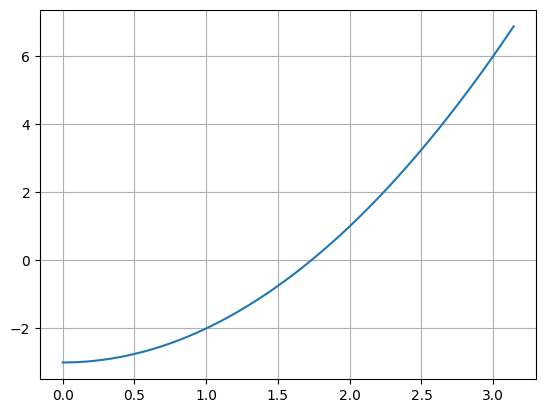

In [17]:
plt.plot(x_grid, h_grid)
plt.grid()

т.к. условие $h(x) < 0$ выполнено не для любого $x$, то метод **неустойчивый!**

## Метод пристрелки
Пусть $y' = \upsilon$, тогда \
$
\begin{cases}
   y' = \upsilon \\
   \upsilon ' + (x^2 - 3) \upsilon + (x^2 - 3)\cos x \cdot y = h(x)\\
   y(0) = 0\\
   y(\pi) = \pi ^ 2
\end{cases}
$\
Перейдем к задаче Коши:\
$
\begin{cases}
   y' = \upsilon \\
   \upsilon ' = - (x^2 - 3) \upsilon - (x^2 - 3)\cos x \cdot y + h(x)\\
   y(0) = 0\\
   \upsilon(0) = \alpha
\end{cases}
$ \
Переобозначим $x \rightarrow t; y \rightarrow x; \upsilon \rightarrow y$\
$
\begin{cases}
   x' = y = f(t, x, y)\\
   y' = - (t^2 - 3) y - (t^2 - 3)\cos t \cdot x + h(t) = g(t, x, y)\\
   x(0) = 0\\
   y(0) = \alpha
\end{cases}
$ \
Решаем систему методом Рунге-Кутты (классическая схема 4 порядка).  Подбор параметра $\alpha$ производим методом половинного деления